In [17]:
# imports
import cv2 # opencv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from skimage import io
from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve
from dataset_generator import get_waldorf_statler_mfcc_features, create_pig_image_dataset, create_swedish_chef_image_dataset

import tensorflow as tf
from tensorflow import keras

# definitons of constants/variables
video_file_glob_path = '../../videos/*.avi'
audio_base_path = '../../audio/'
pig_data_path = '../../ground_truth/pig/'
pig_keras_path = '../../ground_truth/pig_keras/'
pig_label_file = pig_data_path + 'labels.txt'
swedish_chef_data_path = '../../ground_truth/swedish_chef/'
swedish_chef_keras_path = '../../ground_truth/swedish_chef_keras/'
swedish_chef_label_file = swedish_chef_data_path + 'labels.txt'
evaluation_base_path = '../../evaluation/'

label_map = {0: 'kermit_the_frog',
             1: 'waldorf_and_statler',
             2: 'pig',
             3: 'swedish_chef',
             4: 'none'}

In [12]:
def load_pig_image_dataset():
    data = pd.DataFrame([], columns=['name', 'file_id', 'filename', 'contains_character'])

    with open(pig_label_file) as file:
        for i, line in enumerate(file):
            if i == 0:
                continue
            splits = list(map(lambda line: line.strip(), line.split(",")))
            name = splits[0] + '_' + splits[1]
            labels = [int(splits[i]) for i in range(2, len(splits)) if int(splits[i]) != 4]
        
            filename = pig_data_path + name + '_' + splits[2] + '.jpg'
            data = data.append({'name': name,
                                            'file_id': int(splits[0]),
                                            'filename': filename,
                                            'contains_character': 1 if 2 in labels else 0}, ignore_index=True)
    return data

def load_swedish_chef_image_dataset():
    data = pd.DataFrame([], columns=['name', 'file_id', 'filename', 'contains_character'])

    with open(swedish_chef_label_file) as file:
        for i, line in enumerate(file):
            if i == 0:
                continue
            splits = list(map(lambda line: line.strip(), line.split(",")))
            name = splits[0] + '_' + splits[1]
            labels = [int(splits[i]) for i in range(2, len(splits)) if int(splits[i]) != 4]
        
            filename = swedish_chef_data_path + name + '_' + splits[2] + '.jpg'
            data = data.append({'name': name,
                                            'file_id': int(splits[0]),
                                            'filename': filename,
                                            'contains_character': 1 if 3 in labels else 0}, ignore_index=True)
    return data


def train_test_validation_split(df):
    video1_df = df[df['file_id'] == 1]
    video2_df = df[df['file_id'] == 2]
    video3_df = df[df['file_id'] == 3]
    
    train_v1_df, test_v1_df, val_v1_df = np.split(video1_df.sample(frac=1, random_state=42), [int(.6*len(video1_df)), int(.8*len(video1_df))])
    train_v2_df, test_v2_df, val_v2_df = np.split(video2_df.sample(frac=1, random_state=42), [int(.6*len(video2_df)), int(.8*len(video2_df))]) 
    train_v3_df, test_v3_df, val_v3_df = np.split(video3_df.sample(frac=1, random_state=42), [int(.6*len(video3_df)), int(.8*len(video3_df))]) 
    
    train_df = pd.concat([train_v1_df, train_v2_df, train_v3_df]).reset_index(drop=True)
    test_df = pd.concat([test_v1_df, test_v2_df, test_v3_df]).reset_index(drop=True)
    val_df = pd.concat([val_v1_df, val_v2_df, val_v3_df]).reset_index(drop=True)
    
    return train_df, test_df, val_df


In [13]:
# create pig and swedish set image dataset if not exists (this is checked by the function itself)
create_pig_image_dataset()
create_swedish_chef_image_dataset()

# after dataset creation, load it into dataframe
df_pig = load_pig_image_dataset()
df_swedish_chef = load_swedish_chef_image_dataset()

Kermit image dataset already created.
Kermit image dataset already created.


In [36]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
    shear_range=0.15,
    zoom_range=0.2,
    rotation_range=15,
    horizontal_flip=True,
    validation_split=0.2)

df_pig['contains_character'] = df_pig['contains_character'].astype('str') # needed due to class_mode=binary

train_pig = data_generator.flow_from_dataframe(
    df_pig,
    x_col='filename',
    y_col='contains_character',
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    subset='training')

test_pig = data_generator.flow_from_dataframe(
    df_pig,
    x_col='filename',
    y_col='contains_character',
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    subset='validation')

Found 2483 validated image filenames belonging to 2 classes.
Found 620 validated image filenames belonging to 2 classes.


1.0


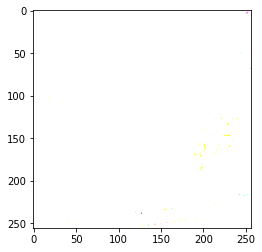

1.0


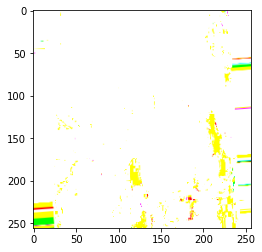

0.0


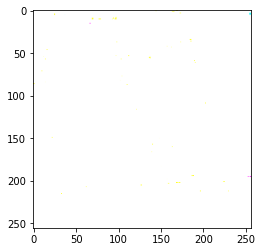

0.0


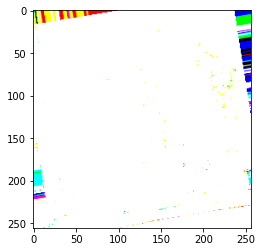

1.0


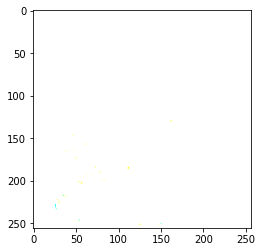

0.0


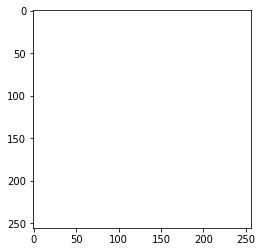

0.0


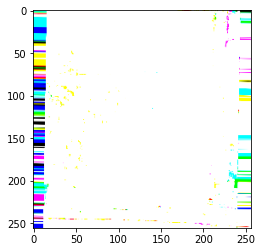

0.0


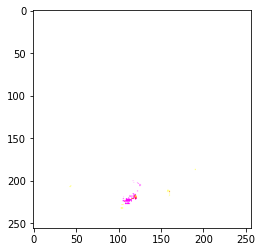

0.0


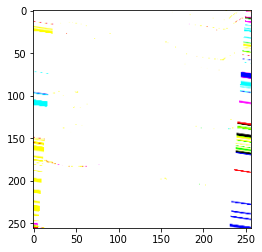

1.0


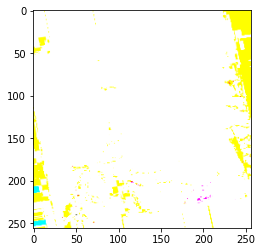

0.0


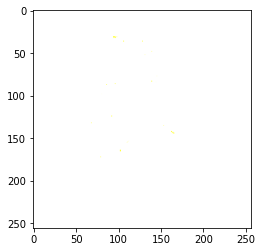

0.0


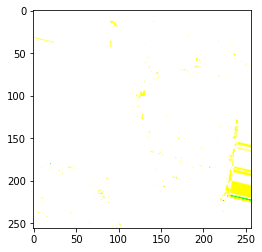

0.0


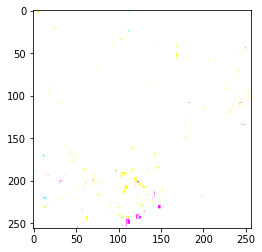

0.0


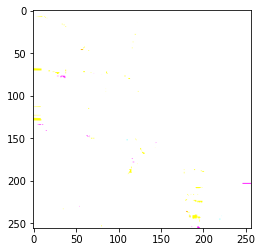

1.0


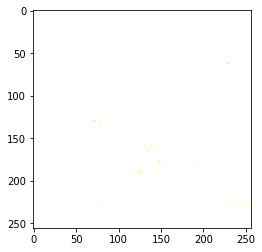

1.0


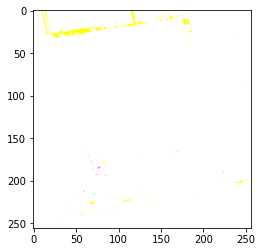

0.0


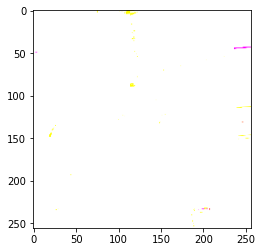

0.0


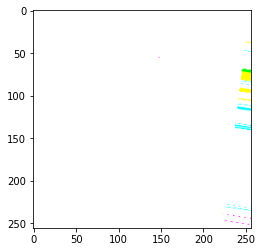

0.0


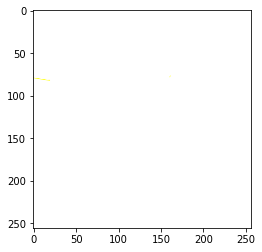

0.0


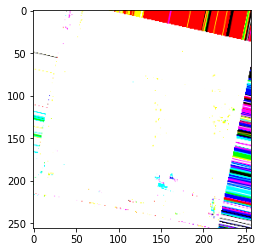

0.0


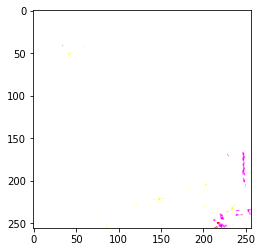

0.0


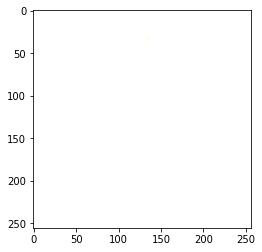

0.0


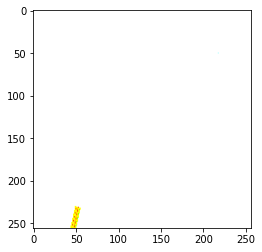

1.0


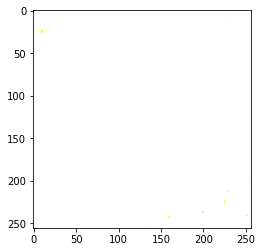

0.0


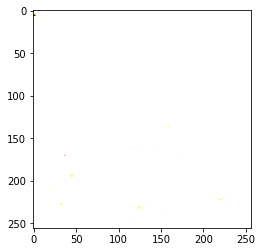

1.0


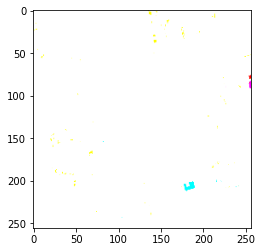

1.0


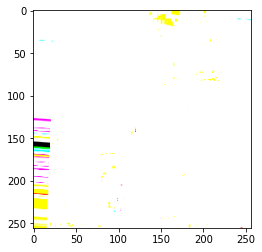

0.0


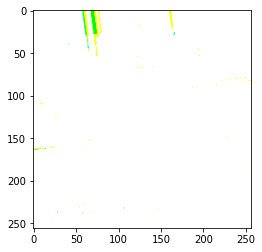

1.0


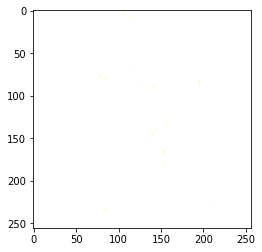

0.0


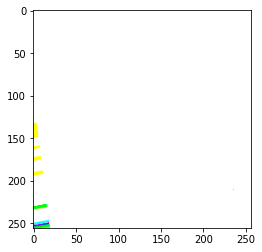

0.0


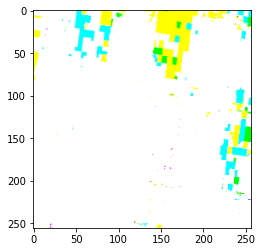

1.0


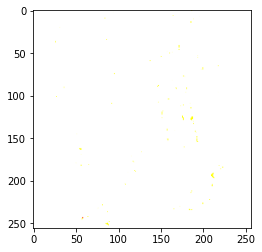

0.0


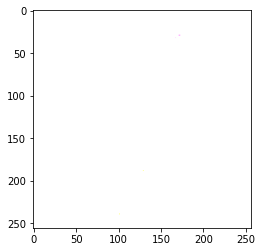

0.0


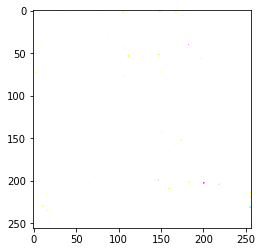

1.0


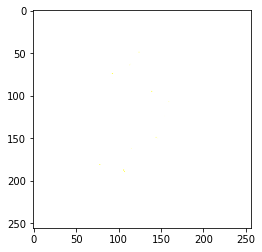

1.0


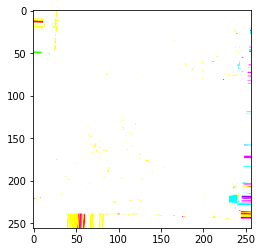

0.0


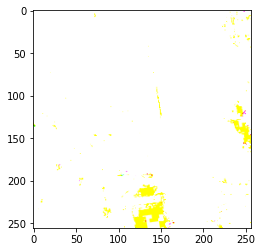

1.0


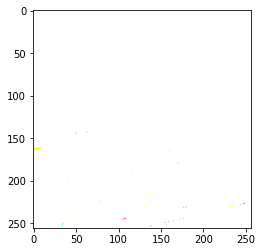

1.0


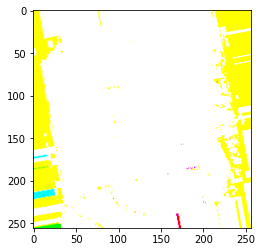

1.0


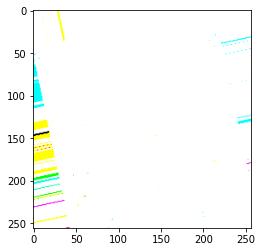

1.0


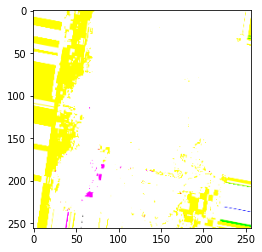

0.0


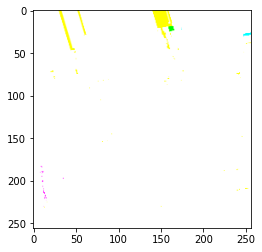

0.0


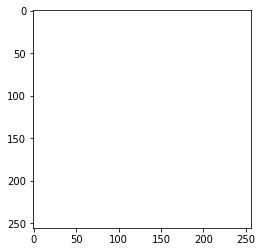

1.0


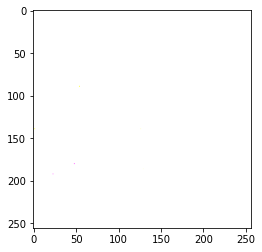

0.0


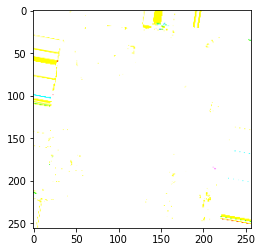

0.0


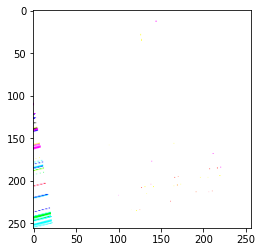

1.0


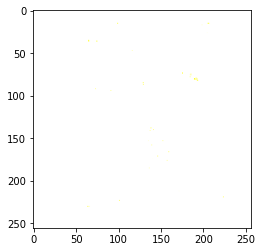

0.0


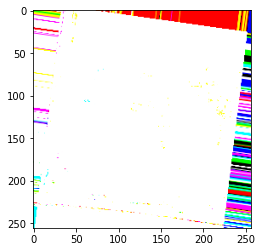

1.0


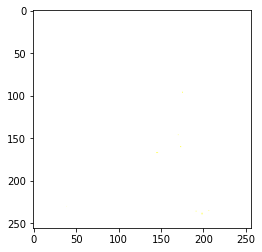

1.0


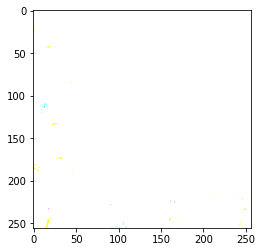

0.0


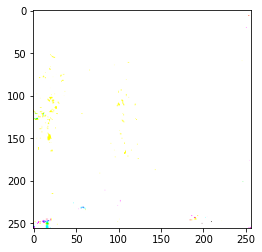

0.0


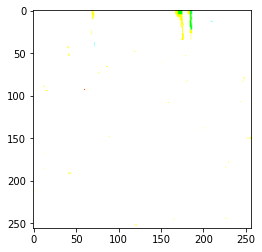

0.0


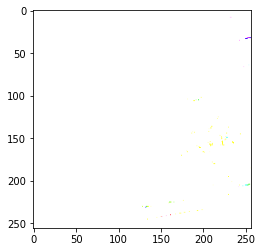

1.0


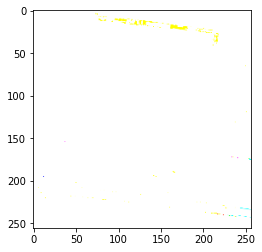

0.0


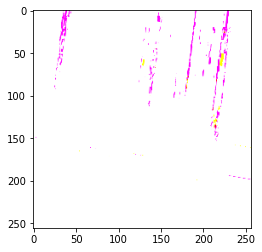

1.0


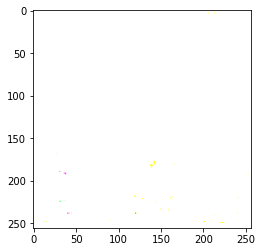

0.0


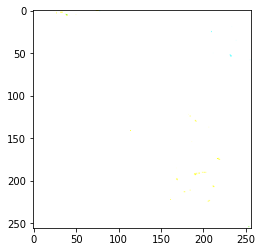

1.0


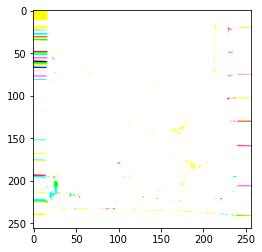

1.0


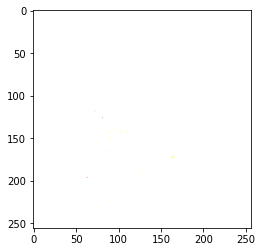

0.0


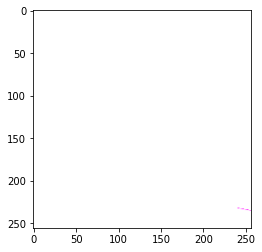

0.0


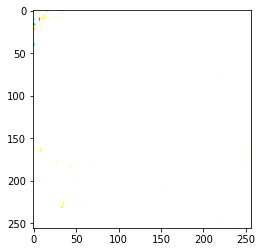

1.0


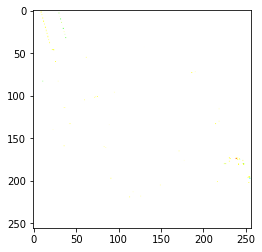

0.0


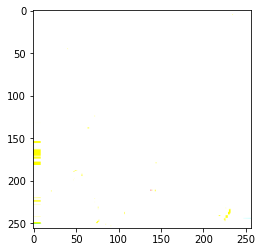

0.0


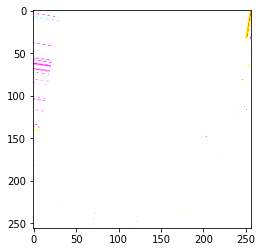

In [33]:
# Visualize images

x_batch, y_batch = next(train_pig)

for i in range (0,64):
    image = x_batch[i]
    print(y_batch[i])
    plt.imshow(image)
    plt.show()

In [37]:
# Create the base model without top layers
vgg16 = tf.keras.applications.VGG16(weights='imagenet',
                                    include_top=False,
                                    input_shape=(256, 256, 3),
                                    pooling='max')
vgg16.summary()

model = keras.models.Sequential()
model.add(vgg16)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

# Optional: freeze VGG16 layers
#for layer in vgg16.layers:
#    layer.trainable = False
#vgg16.trainable = False

model.compile(
    optimizer=keras.optimizers.SGD(0.02),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.TruePositives(), keras.metrics.FalsePositives()],
)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [67]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="model.ckpt",
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(train_pig, validation_data=test_pig, epochs=1, callbacks=[cp_callback])

39/39 [==============================] - ETA: 0s - loss: 0.3479 - binary_accuracy: 0.8542 - precision_5: 0.8024 - recall_5: 0.8093 - true_positives_5: 751.0000 - false_positives_5: 185.0000
Epoch 00001: saving model to model.ckpt
39/39 [==============================] - 403s 10s/step - loss: 0.3479 - binary_accuracy: 0.8542 - precision_5: 0.8024 - recall_5: 0.8093 - true_positives_5: 751.0000 - false_positives_5: 185.0000 - val_loss: 2.1866 - val_binary_accuracy: 0.1113 - val_precision_5: 1.0000 - val_recall_5: 0.1113 - val_true_positives_5: 69.0000 - val_false_positives_5: 0.0000e+00


In [69]:
model.save("model.h5")

In [ ]:
# Load the saved model

model = keras.models.load_model('model.h5')

In [71]:
model.evaluate(test_pig)

10/10 [==============================] - 23s 2s/step - loss: 2.1291 - binary_accuracy: 0.1258 - precision_5: 1.0000 - recall_5: 0.1258 - true_positives_5: 78.0000 - false_positives_5: 0.0000e+00


[2.1290884017944336, 0.12580645084381104, 1.0, 0.12580645084381104, 78.0, 0.0]

dict_keys(['loss', 'binary_accuracy', 'precision_5', 'recall_5', 'true_positives_5', 'false_positives_5', 'val_loss', 'val_binary_accuracy', 'val_precision_5', 'val_recall_5', 'val_true_positives_5', 'val_false_positives_5'])


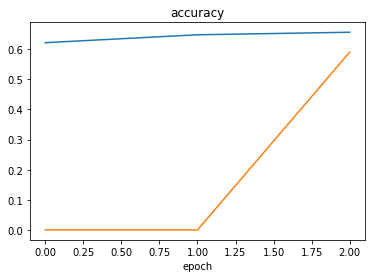

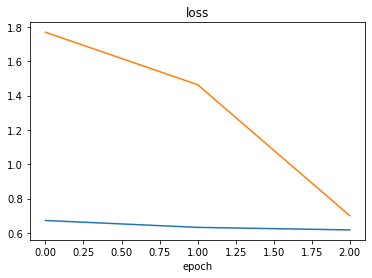

In [41]:
print(history.history.keys())

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('accuracy')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.xlabel('epoch')
plt.show()


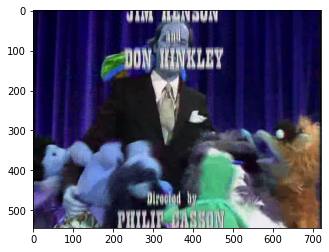

file: ../../ground_truth/pig/2_37513_2.jpg
no pig
[[0.31103915]]


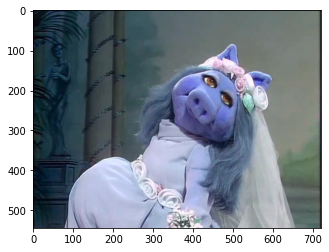

file: ../../ground_truth/pig/2_19681_2.jpg
no pig
[[0.21915403]]


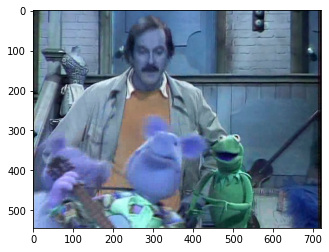

file: ../../ground_truth/pig/2_8785_2.jpg
pig
[[0.9103536]]


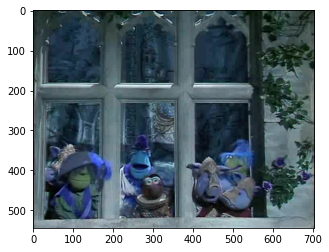

file: ../../ground_truth/pig/3_17090_2.jpg
pig
[[0.6852994]]


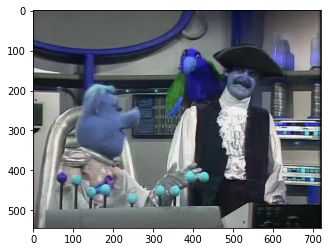

file: ../../ground_truth/pig/2_13213_2.jpg
no pig
[[0.2729743]]


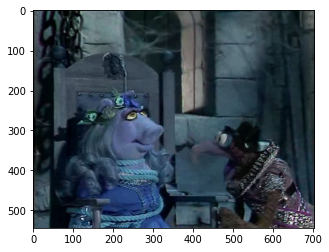

file: ../../ground_truth/pig/3_32450_2.jpg
pig
[[0.8184945]]


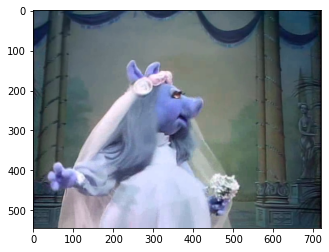

file: ../../ground_truth/pig/2_21877_2.jpg
pig
[[0.8669875]]


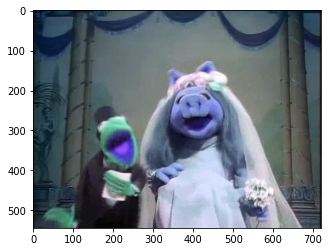

file: ../../ground_truth/pig/2_22165_2.jpg
pig
[[0.84610415]]


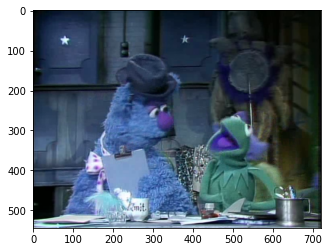

file: ../../ground_truth/pig/1_10012_0.jpg
no pig
[[0.21740654]]


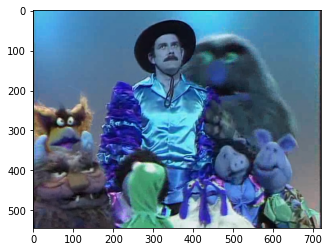

file: ../../ground_truth/pig/2_35641_0.jpg
pig
[[0.6163551]]


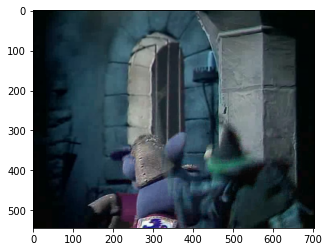

file: ../../ground_truth/pig/3_29834_0.jpg
pig
[[0.92763877]]


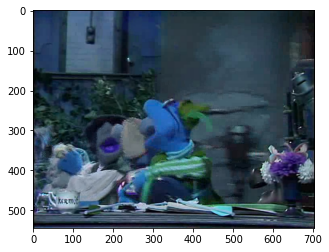

file: ../../ground_truth/pig/3_15986_4.jpg
pig
[[0.6412536]]


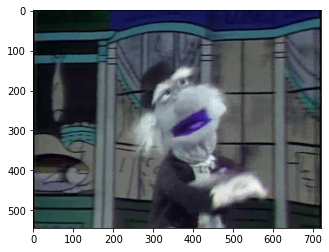

file: ../../ground_truth/pig/1_22276_4.jpg
no pig
[[0.07902992]]


In [66]:
# Classify an image

def is_this_a_pig(file):
    img = cv2.imread(file)
    plt.imshow(img)
    plt.show()
    img = cv2.resize(img, (256, 256))
    img = np.expand_dims(img, axis=0)
    img = img.astype(np.float32) / 255.0
    prediction = model.predict(img)
    print("file: " + file)
    if prediction[0][0] < 0.5:
        print("no pig")
    else:
        print("pig")
    print(prediction)
    
is_this_a_pig('../../ground_truth/pig/2_37513_2.jpg')
is_this_a_pig('../../ground_truth/pig/2_19681_2.jpg')
is_this_a_pig('../../ground_truth/pig/2_8785_2.jpg')
is_this_a_pig('../../ground_truth/pig/3_17090_2.jpg')
is_this_a_pig('../../ground_truth/pig/2_13213_2.jpg')
is_this_a_pig('../../ground_truth/pig/3_32450_2.jpg')
is_this_a_pig('../../ground_truth/pig/2_21877_2.jpg')
is_this_a_pig('../../ground_truth/pig/2_22165_2.jpg')
is_this_a_pig('../../ground_truth/pig/1_10012_0.jpg')
is_this_a_pig('../../ground_truth/pig/2_35641_0.jpg')
is_this_a_pig('../../ground_truth/pig/3_29834_0.jpg')
is_this_a_pig('../../ground_truth/pig/3_15986_4.jpg')
is_this_a_pig('../../ground_truth/pig/1_22276_4.jpg')